# Определение возраста покупателей

В данной задаче нам предлагается научиться определять возраст покупателей по фотографии. Решаем задачу регрессии. В качестве модели будем брать ResNet и дообучать ее под нашу задачу. Итоговая метрика: MAE. Не должна превышать 8

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
text_data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
text_data.head(5)

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

#### Размер выборки

In [4]:
text_data.shape

(7591, 2)

7591 фотография в датасете. Данных не так уж много. Здесь можно, например, обучать не всю модель, а удалить из предобученной уже модели верхнии слои, добавить свои и обучать только их. Также можно добавить аугментацию изображений, чтобы расширить диапазон фотографий. (Повороты, оттенки, сжатия)

#### График распределения возраста в выборке

In [5]:
plt.title("График распределения возраста")
plt.hist(text_data['real_age'], bins=100)
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.grid()
plt.show()

Некоторые возрасты выбиваются из нормального распределения.

In [6]:
text_data['real_age'] = text_data['real_age'].values.tolist()

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255
)

temp_flow = datagen.flow_from_dataframe(
    text_data,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224,224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

Found 7591 validated image filenames.


In [8]:
images, labels = next(temp_flow)

In [9]:
C = 10
images = images[:C,:,:,:]
labels = labels[:C]

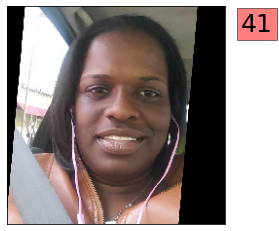

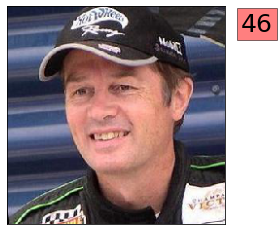

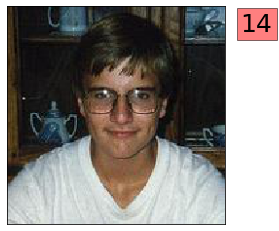

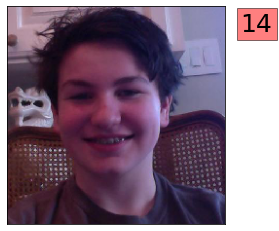

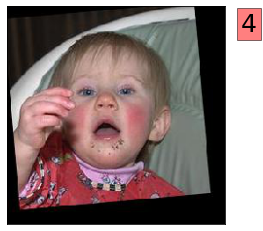

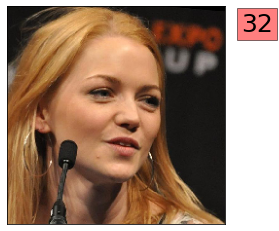

In [10]:
for i in range(C):
    plt.imshow(images[i])
    plt.text(240, 25, str(labels[i]), fontsize=25,
            bbox=dict(facecolor='red', alpha=0.5))
    plt.tick_params(left=False, bottom=False,
                   labelleft=False, labelbottom=False)
    plt.show()

Несмотря на небольшое количество фотографий во всем датасете (7591), качество самих фотографий приемлимое. Что касается возраста, то данный показатель показал довольно естественное распределение. Преобладает: от 18 до 40 лет. Датасет очень хороший, так как фотографии людей "не как на паспорт", т.е. в различных ракурсах, с различными элементами одежды, с различными эмоциями и источниками освещения. Есть черно-белые фото. 

## Обучение модели

Код, запущенный на GPU кластере

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/20

2023-12-28 06:42:24.532412: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-12-28 06:42:25.708252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 66s - loss: 206.5316 - mae: 10.9098 - val_loss: 1158.0676 - val_mae: 29.6162

Epoch 2/20

356/356 - 40s - loss: 133.2195 - mae: 8.8163 - val_loss: 307.0366 - val_mae: 13.0418

Epoch 3/20

356/356 - 39s - loss: 111.4274 - mae: 8.0918 - val_loss: 108.9004 - val_mae: 7.8957

Epoch 4/20

356/356 - 40s - loss: 92.7146 - mae: 7.3638 - val_loss: 145.7712 - val_mae: 9.0480

Epoch 5/20

356/356 - 39s - loss: 80.5116 - mae: 6.8362 - val_loss: 109.7902 - val_mae: 8.0026

Epoch 6/20

356/356 - 39s - loss: 62.7542 - mae: 6.0618 - val_loss: 162.5843 - val_mae: 9.2884

Epoch 7/20

356/356 - 39s - loss: 59.1077 - mae: 5.9109 - val_loss: 109.1743 - val_mae: 8.1616

Epoch 8/20

356/356 - 39s - loss: 44.8019 - mae: 5.1243 - val_loss: 100.0336 - val_mae: 7.8464

Epoch 9/20

356/356 - 39s - loss: 38.3056 - mae: 4.7710 - val_loss: 116.9598 - val_mae: 8.2096

Epoch 10/20

356/356 - 41s - loss: 32.6647 - mae: 4.3609 - val_loss: 107.5410 - val_mae: 7.7735

Epoch 11/20

356/356 - 43s - loss: 30.6503 - mae: 4.2444 - val_loss: 135.9786 - val_mae: 8.5994

Epoch 12/20

356/356 - 42s - loss: 27.8504 - mae: 4.0746 - val_loss: 90.9106 - val_mae: 7.3515

Epoch 13/20

356/356 - 41s - loss: 28.3619 - mae: 4.0937 - val_loss: 85.5568 - val_mae: 6.9371

Epoch 14/20

356/356 - 41s - loss: 24.7865 - mae: 3.8172 - val_loss: 88.7942 - val_mae: 6.9690

Epoch 15/20

356/356 - 42s - loss: 21.4134 - mae: 3.5747 - val_loss: 112.6529 - val_mae: 8.1106

Epoch 16/20

356/356 - 42s - loss: 19.6280 - mae: 3.3734 - val_loss: 84.4473 - val_mae: 7.1761

Epoch 17/20

356/356 - 41s - loss: 18.9604 - mae: 3.3545 - val_loss: 85.3129 - val_mae: 7.0126

Epoch 18/20

356/356 - 41s - loss: 17.2015 - mae: 3.1757 - val_loss: 90.2285 - val_mae: 7.1855

Epoch 19/20

356/356 - 41s - loss: 17.3964 - mae: 3.2056 - val_loss: 101.8813 - val_mae: 7.7792

Epoch 20/20

356/356 - 42s - loss: 17.5950 - mae: 3.2129 - val_loss: 96.2914 - val_mae: 7.1901

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 10s - loss: 96.2914 - mae: 7.1901

```

## Анализ обученной модели

Мы дообучили сверточную нейронную сеть ResNet50 под задачу регрессии, то есть определения возраста человека по его фотографии. Итоговая метрика MAE: 7,19.